 This file replicate the data analysis process on time series analysis for data quality monitoring 

In [1]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #v3.4.3
import matplotlib
import seaborn as sns
import mplhep as hep
import ast
from statsmodels.tsa.stattools import acf
from omsapi import OMSAPI
import scipy.signal as signal
import matplotlib.colors as mcolors

In [2]:
plt.style.use([hep.style.ROOT, hep.style.firamath])
hep.rcParams.label.data = True
hep.rcParams.label.paper = False

## Definition

In [3]:
monitoring_elements = ['chargeInner_PXLayer_1',
                       'chargeInner_PXLayer_2',
                       'chargeInner_PXLayer_3',
                       'chargeInner_PXLayer_4',
                       'size_PXLayer_1',
                       'size_PXLayer_2',
                       'size_PXLayer_3',
                       'size_PXLayer_4']     

In [4]:
essential_columns = ['fromrun','fromlumi','hname','histo','Xmin','Xmax','Xbins','entries']

In [5]:
def extract_histo(df,histo_name):
    sub_df = df.copy()
    sub_df = sub_df[sub_df.hname == histo_name]
    sub_df = sub_df[essential_columns]
    return sub_df

In [6]:
def histogram_plot(run = 315721, lumisection = 252, histo='histo_list',color='k') : 
    display_data = df_test_run[(df_test_run.hname == 'chargeInner_PXLayer_1')&(df_test_run.fromlumi == lumisection)][[histo,'fromrun','fromlumi','hname']]
    #print(display_data)
    index_number = display_data.index[0]
    #print(index_number)
    plt.bar(range(102),display_data[histo].get(index_number),color=color)
    plt.xlabel('Charge',fontsize = 'x-large')
    plt.ylabel('Count', fontsize = 'x-large')
    plt.xticks(fontsize = 'large')
    plt.yticks(fontsize = 'large')
    #plt.plot(display_data[histo].get(index_number))
    #plt.axvline(x=mean_test_run['chargeInner_PXLayer_1'][lumisection],color=color,label='Mean')
    #plt.title('Run '+str(run))
    plt.legend(title='Pixel Layer 1\n'
               #display_data['hname'][index_number]+'\n'+
               'Lumisection '+str(display_data['fromlumi'][index_number])+'\nEntries '+str(df_entries['entries'][lumisection])+"\nMean %.2f"%mean_test_run['chargeInner_PXLayer_1'][lumisection],title_fontsize = 'x-large')   
    #plt.legend(title="Mean %.2f"%mean_test_run['chargeInner_PXLayer_1'][lumisection]+'\nEntries '+str(df_entries['entries'][lumisection])+'\nLumisection '+str(display_data['fromlumi'][index_number])+'\n'+display_data['hname'][index_number])   
    return

In [7]:
def colorplot(df,hname,run,col_name):
    histo_ts = df[(df.hname == hname) & (df.fromrun == run)][col_name]
    color_histo_list = pd.DataFrame([])
    i=0
    for info in histo_ts: 
        i+=1
        color_histo_list = pd.concat((color_histo_list,pd.DataFrame(info,columns=[str(i)])),axis = 1)
    c = plt.pcolormesh(color_histo_list.values)
    #plt.colorbar(c)
    plt.xlabel('Lumisection')
    plt.ylabel(hname)     
    #plt.title(hname)
    plt.tight_layout()
    return 

In [8]:
def stat_eval(df,run,eval_col='histo_list',mean_col='mean',std_col = False):
    df_cal = df[df.fromrun == run].copy()
    mean_list = []
    std_list = []
    j = 0 
    for index,row in df_cal.iterrows():
        mean_val = 0
        sigma_val = 0 
        histo_list = row[eval_col]
        Xbins = row['Xbins']
        entries = row['entries']
        if entries == 0 :
            meal_val = 0
            sigma_val = 0 
        else :    
            for i in range(len(histo_list)):
                mean_val += histo_list[i]*i/(sum(histo_list)-histo_list[0]-histo_list[1])
            if std_col != False :
                for i in range(1,len(histo_list)-1):
                    sigma_val += histo_list[i]*(i-mean_val)**2.0 #not divided by N-1 
        mean_list.append(mean_val)
        if std_col != False : 
            std_val = np.sqrt(sigma_val/(entries - 1))
            std_list.append(std_val)
    df_cal[mean_col] = mean_list
    if std_col != False : 
        df_cal[std_col] = std_list
    return df_cal

In [9]:
def norm_histo(df):
    normalized_histogram_list = []
    for i in range(min(df.index),max(df.index)+1):
        if sum(df.histo_list[i][1:101]) == 0: #not include the overbin
            normalized_histogram_list.append((df.histo_list[i]))
        else :
            normalized_histogram_list.append((list(map(lambda x: x/sum(df.histo_list[i][1:101]), df.histo_list[i]))))
    #print(normalized_histogram_list[100:200])
    df['norm_histo_list'] = normalized_histogram_list
    return df_test_run

## Monitoring Histogram Fetching

In [10]:
folder = '/eos/project/c/cmsml4dc/ML_2020/UL2018_Data/DF2018A_1D_Complete/'

In [11]:
list_of_files = glob("/eos/project/c/cmsml4dc/ML_2020/UL2018_Data/DF2018A_1D_Complete/*.csv")

In [12]:
len(list_of_files)

70

In [13]:
df_all_files = pd.DataFrame(columns=essential_columns)
for file in list_of_files:
    transcient_df = pd.read_csv(file)
    for me in monitoring_elements : 
        df_all_files = pd.concat([df_all_files,extract_histo(transcient_df,me)])

In [14]:
df_all_files['histo_list'] = df_all_files['histo'].apply(lambda x : ast.literal_eval(x))
df_all_files.sort_values(by=["fromrun", "fromlumi"], inplace=True)
df_all_files.reset_index(inplace=True, drop=True)
df_all_files.tail()

,fromrun,fromlumi,hname,histo,Xmin,Xmax,Xbins,entries,histo_list
489219,316995,638,chargeInner_PXLayer_4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
489220,316995,638,size_PXLayer_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,30.0,30,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
489221,316995,638,size_PXLayer_2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,30.0,30,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
489222,316995,638,size_PXLayer_3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,30.0,30,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
489223,316995,638,size_PXLayer_4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,30.0,30,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Data Preparation

### Run Selection

In [15]:
df_all_files.fromrun.unique()

array([315257, 315258, 315259, 315264, 315265, 315267, 315270, 315322,
       315339, 315357, 315361, 315363, 315365, 315366, 315420, 315488,
       315489, 315490, 315506, 315509, 315510, 315512, 315543, 315555,
       315556, 315557, 315640, 315641, 315642, 315644, 315645, 315646,
       315647, 315648, 315689, 315690, 315702, 315703, 315704, 315705,
       315713, 315721, 315741, 315764, 315770, 315784, 315785, 315786,
       315790, 315800, 315801, 315840, 315973, 315974, 316058, 316059,
       316060, 316061, 316062, 316082, 316109, 316110, 316111, 316112,
       316113, 316114, 316151, 316153, 316186, 316187, 316199, 316200,
       316201, 316202, 316216, 316217, 316218, 316219, 316239, 316240,
       316241, 316271, 316361, 316362, 316363, 316377, 316378, 316379,
       316380, 316455, 316456, 316457, 316469, 316470, 316472, 316505,
       316569, 316590, 316613, 316615, 316664, 316665, 316666, 316667,
       316700, 316701, 316702, 316715, 316716, 316717, 316718, 316719,
      

In [16]:
test_run = 316613

### Histogram Preparation

In [17]:
df_test_run = stat_eval(df_all_files,test_run,eval_col='histo_list',mean_col='mean',std_col='std')
df_test_run =df_test_run.reset_index(drop=True)
df_test_run = norm_histo(df_test_run)
df_test_run.head()

,fromrun,fromlumi,hname,histo,Xmin,Xmax,Xbins,entries,histo_list,mean,std,norm_histo_list
0,316613,1,chargeInner_PXLayer_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,-0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,316613,1,chargeInner_PXLayer_2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,-0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,316613,1,chargeInner_PXLayer_3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,-0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,316613,1,chargeInner_PXLayer_4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,-0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,316613,1,size_PXLayer_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,30.0,30,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,-0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [18]:
mean_test_run = df_test_run.pivot_table(index=['fromlumi'],columns='hname')['mean']
mean_test_run.head()

hname,chargeInner_PXLayer_1,chargeInner_PXLayer_2,chargeInner_PXLayer_3,chargeInner_PXLayer_4,size_PXLayer_1,size_PXLayer_2,size_PXLayer_3,size_PXLayer_4
fromlumi,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
std_test_run = df_test_run.pivot_table(index=['fromlumi'],columns='hname')['std']
std_test_run.head()

hname,chargeInner_PXLayer_1,chargeInner_PXLayer_2,chargeInner_PXLayer_3,chargeInner_PXLayer_4,size_PXLayer_1,size_PXLayer_2,size_PXLayer_3,size_PXLayer_4
fromlumi,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_entries = df_all_files[(df_all_files.hname=='chargeInner_PXLayer_1')&(df_all_files.fromrun==test_run)].set_index('fromlumi')
df_entries.head()

,fromrun,hname,histo,Xmin,Xmax,Xbins,entries,histo_list
fromlumi,,,,,,,,
1,316613,chargeInner_PXLayer_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,316613,chargeInner_PXLayer_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,316613,chargeInner_PXLayer_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,316613,chargeInner_PXLayer_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,316613,chargeInner_PXLayer_1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,80000.0,100,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## False in Physics

In [21]:
omsapi = OMSAPI(api_url="https://vocms0185.cern.ch/agg/api", api_version="v1", cert_verify=False)
omsapi.auth_oidc("oms-api-client", "4577f6da-bbf7-4f5e-a898-f8db325e7e5e", audience="cmsoms-int-0185")
q = omsapi.query('lumisections').paginate(page=1,per_page=1000).filter("run_number",test_run)
response_data = q.data()
folded_json = response_data.json()

https://vocms0185.cern.ch/agg/api/v1/lumisections/?filter[run_number][EQ]=316613&page[offset]=0&page[limit]=1000


In [22]:
dcs_bit = pd.json_normalize(folded_json['data'])
dcs_bit.head()

,id,type,attributes.beam1_present,attributes.bpix_ready,attributes.ho_ready,attributes.dtp_ready,attributes.tecm_ready,attributes.delivered_lumi_per_lumisection,attributes.recorded_lumi_per_lumisection,attributes.castor_ready,...,attributes.beam2_present,relationships.run.links.self,relationships.run.links.related,links.self,meta.row.init_lumi.units,meta.row.recorded_lumi.units,meta.row.delivered_lumi.units,meta.row.delivered_lumi_per_lumisection.units,meta.row.recorded_lumi_per_lumisection.units,meta.row.end_lumi.units
0,316613_1,lumisections,True,False,True,False,False,0.0,0.0,False,...,True,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,10^{34}cm^{-2}s^{-1},pb^{-1},pb^{-1},pb^{-1},pb^{-1},10^{34}cm^{-2}s^{-1}
1,316613_2,lumisections,True,False,True,False,False,0.0,0.0,False,...,True,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,10^{34}cm^{-2}s^{-1},pb^{-1},pb^{-1},pb^{-1},pb^{-1},10^{34}cm^{-2}s^{-1}
2,316613_3,lumisections,True,False,True,False,False,0.0,0.0,False,...,True,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,10^{34}cm^{-2}s^{-1},pb^{-1},pb^{-1},pb^{-1},pb^{-1},10^{34}cm^{-2}s^{-1}
3,316613_4,lumisections,True,False,True,False,False,0.0,0.0,False,...,True,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,10^{34}cm^{-2}s^{-1},pb^{-1},pb^{-1},pb^{-1},pb^{-1},10^{34}cm^{-2}s^{-1}
4,316613_5,lumisections,True,False,True,False,False,0.0,0.0,False,...,True,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,https://https://vocms0185.cern.ch/agg/api/v1/l...,10^{34}cm^{-2}s^{-1},pb^{-1},pb^{-1},pb^{-1},pb^{-1},10^{34}cm^{-2}s^{-1}


In [23]:
dcs_monitoring = ['attributes.cscm_ready',
                  'attributes.beam1_stable',
                  'attributes.beam1_present',
                  'attributes.bpix_ready',
                  'attributes.cms_active',
                  'attributes.cscp_ready',
                  'attributes.dt0_ready',
                  'attributes.dtm_ready',
                  'attributes.dtp_ready',
                  'attributes.ebm_ready',
                  'attributes.ebp_ready',
                  'attributes.eem_ready',
                  'attributes.eep_ready',
                  'attributes.esm_ready',
                  'attributes.esp_ready',
                  'attributes.fpix_ready',
                  'attributes.hbhea_ready',
                  'attributes.hbheb_ready',
                  'attributes.hbhec_ready',
                  'attributes.hf_ready',
                  'attributes.ho_ready',
                  'attributes.rpc_ready',
                  'attributes.tecm_ready',
                  'attributes.tecp_ready',
                  'attributes.tibtid_ready',
                  'attributes.tob_ready']
                

In [24]:
"""
# These following code line are used for extracitng the lumisection at which some of dcs-bits turns off
false_list = []
for j in range(max(dcs_bit.index)):
    for i in dcs_monitoring : 
        if dcs_bit[i][j] == False :
            false_list.append(dcs_bit['id'][j])
            break
false_lumi_list = [int(i.split(str(test_run)+'_')[1]) for i in false_list]
"""

#These following code line are the code for getting the lumiesction at which physics is false 
false_list = []
for j in range(max(dcs_bit.index)):
    if dcs_bit['attributes.physics_flag'][j] == False :
        false_list.append(dcs_bit['id'][j])
false_lumi_list = [int(i.split(str(test_run)+'_')[1]) for i in false_list]

### Datasetrates

In [25]:
omsapi = OMSAPI(api_url="https://vocms0185.cern.ch/agg/api", api_version="v1", cert_verify=False)
omsapi.auth_oidc("oms-api-client", "4577f6da-bbf7-4f5e-a898-f8db325e7e5e", audience="cmsoms-int-0185")
q = omsapi.query('datasetrates').paginate(page=1,per_page=1000).filter('run_number',test_run).filter('dataset_name','ZeroBias')
response_data = q.data()
folded_json = response_data.json()

https://vocms0185.cern.ch/agg/api/v1/datasetrates/?filter[run_number][EQ]=316613&filter[dataset_name][EQ]=ZeroBias&page[offset]=0&page[limit]=1000


In [26]:
df_zerobias = pd.json_normalize(folded_json['data'])
df_zerobias = df_zerobias.rename(columns={'attributes.first_lumisection_number':'Lumisection'})
df_zerobias.set_index('Lumisection',inplace=True)
df_zerobias.head()

,id,type,attributes.start_time,attributes.last_lumisection_number,attributes.rate,attributes.run_number,attributes.last_lumisection_in_run,attributes.dataset_name,attributes.cms_active,attributes.events,links.self
Lumisection,,,,,,,,,,,
11,316613__ZeroBias__11,datasetrates,2018-05-20T07:37:35Z,11,91.847378,316613,241,ZeroBias,True,2141,https://https://vocms0185.cern.ch/agg/api/v1/d...
12,316613__ZeroBias__12,datasetrates,2018-05-20T07:37:59Z,12,92.405069,316613,241,ZeroBias,True,2154,https://https://vocms0185.cern.ch/agg/api/v1/d...
13,316613__ZeroBias__13,datasetrates,2018-05-20T07:38:22Z,13,94.335537,316613,241,ZeroBias,True,2199,https://https://vocms0185.cern.ch/agg/api/v1/d...
14,316613__ZeroBias__14,datasetrates,2018-05-20T07:38:45Z,14,89.745313,316613,241,ZeroBias,True,2092,https://https://vocms0185.cern.ch/agg/api/v1/d...
15,316613__ZeroBias__15,datasetrates,2018-05-20T07:39:08Z,15,90.560399,316613,241,ZeroBias,True,2111,https://https://vocms0185.cern.ch/agg/api/v1/d...


# Data Display

In [27]:
# This is manual criteria for getting the lumisection at which histogram/rate is anomalous, says histogram mean/rate are change significantly compared to the neighbour lumisections or behave uncommon ways.
rate_peak_list = df_zerobias[(df_zerobias['attributes.rate']<60) & (df_zerobias['attributes.rate']>15)]['attributes.rate'].index
histo_peak_list = std_test_run[(std_test_run['chargeInner_PXLayer_1']>10)&(std_test_run['chargeInner_PXLayer_1']<12)].index

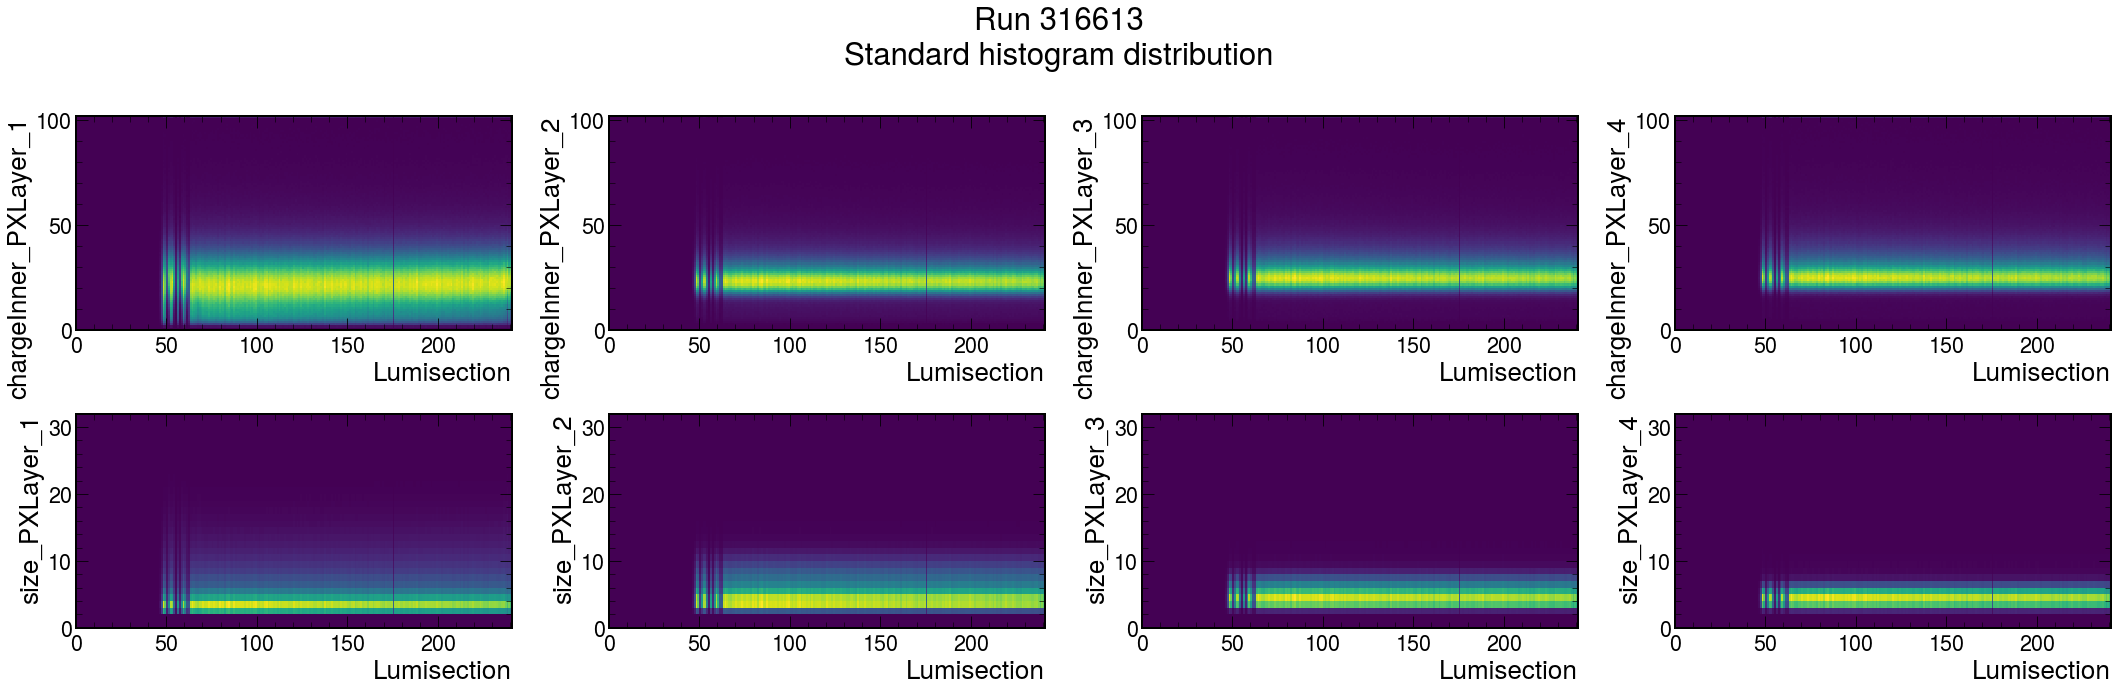

In [28]:
f,axs = plt.subplots(2,4,figsize=(30,10))
i=0
for me in monitoring_elements : 
    i+=1
    plt.subplot(2,4,i)
    colorplot(df_test_run,me,test_run,col_name='histo_list')
plt.suptitle('Run '+str(test_run)+'\nStandard histogram distribution')
plt.tight_layout()

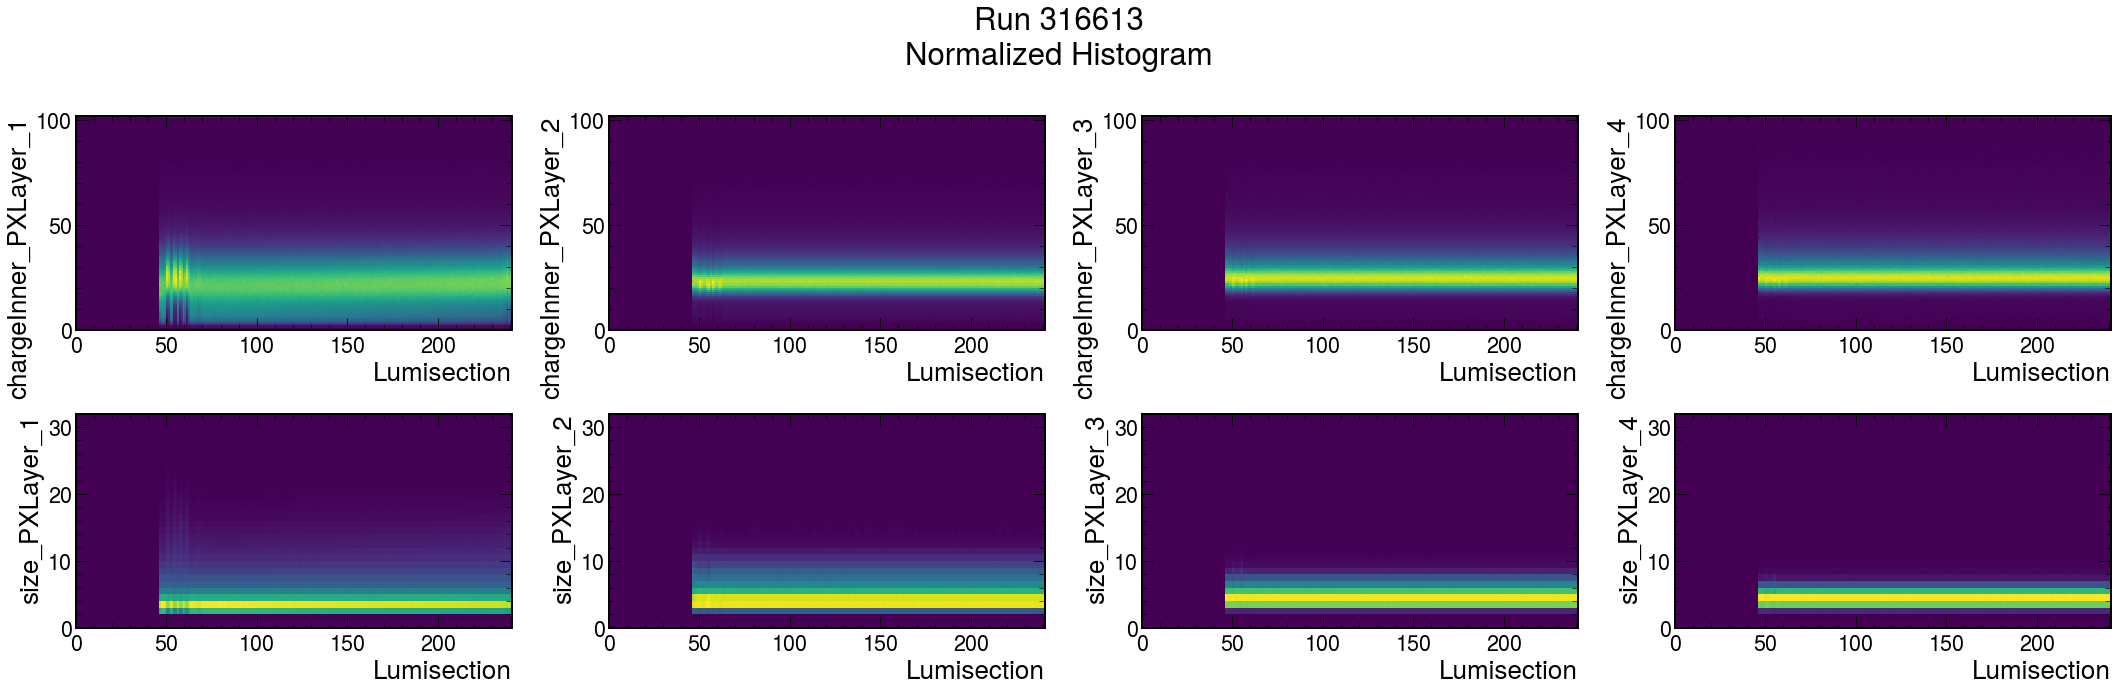

In [29]:
f,axs = plt.subplots(2,4,figsize=(30,10))
i = 0
for me in monitoring_elements : 
    i+=1
    plt.subplot(2,4,i)
    colorplot(df_test_run,me,test_run,col_name='norm_histo_list')
plt.suptitle('Run '+str(test_run)+'\nNormalized Histogram')
plt.tight_layout()

Text(0.5, 0.98, 'Run 316613')

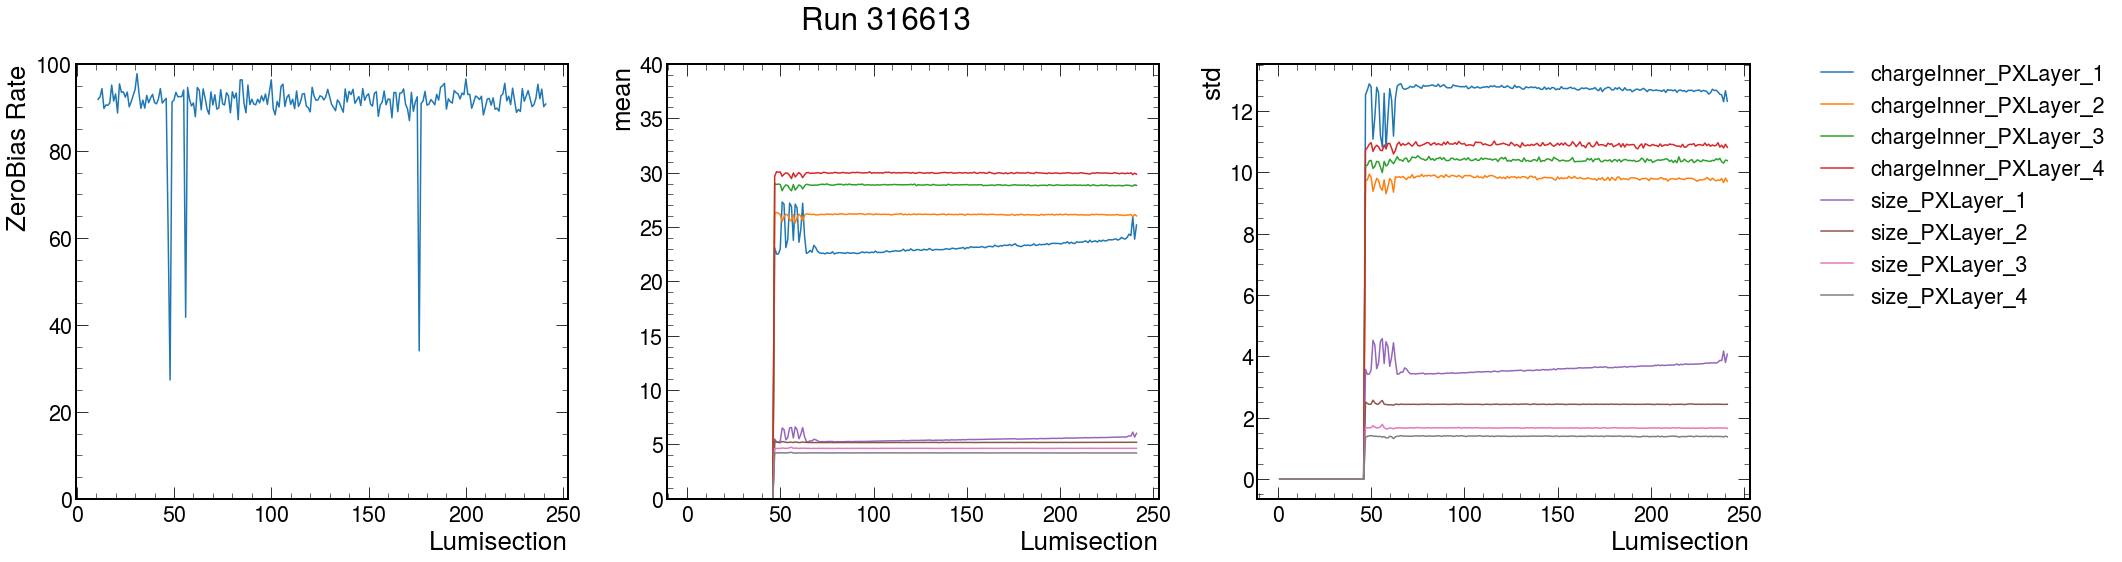

In [30]:
plt.subplots(figsize=(30,8))
plt.subplot(131)
plt.plot(df_zerobias['attributes.rate'])
plt.xlabel('Lumisection')
plt.ylabel('ZeroBias Rate')
plt.ylim([0,100])

plt.subplot(132)
for me in monitoring_elements:
    plt.plot(mean_test_run[me],label=me)
    plt.ylim(0,40)
    plt.ylabel('mean')
    plt.xlabel('Lumisection')

plt.subplot(133)
for me in monitoring_elements:
    plt.plot(std_test_run[me],label=me)
    plt.xlabel('Lumisection')
    plt.ylabel('std')
    plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.suptitle('Run '+str(test_run))

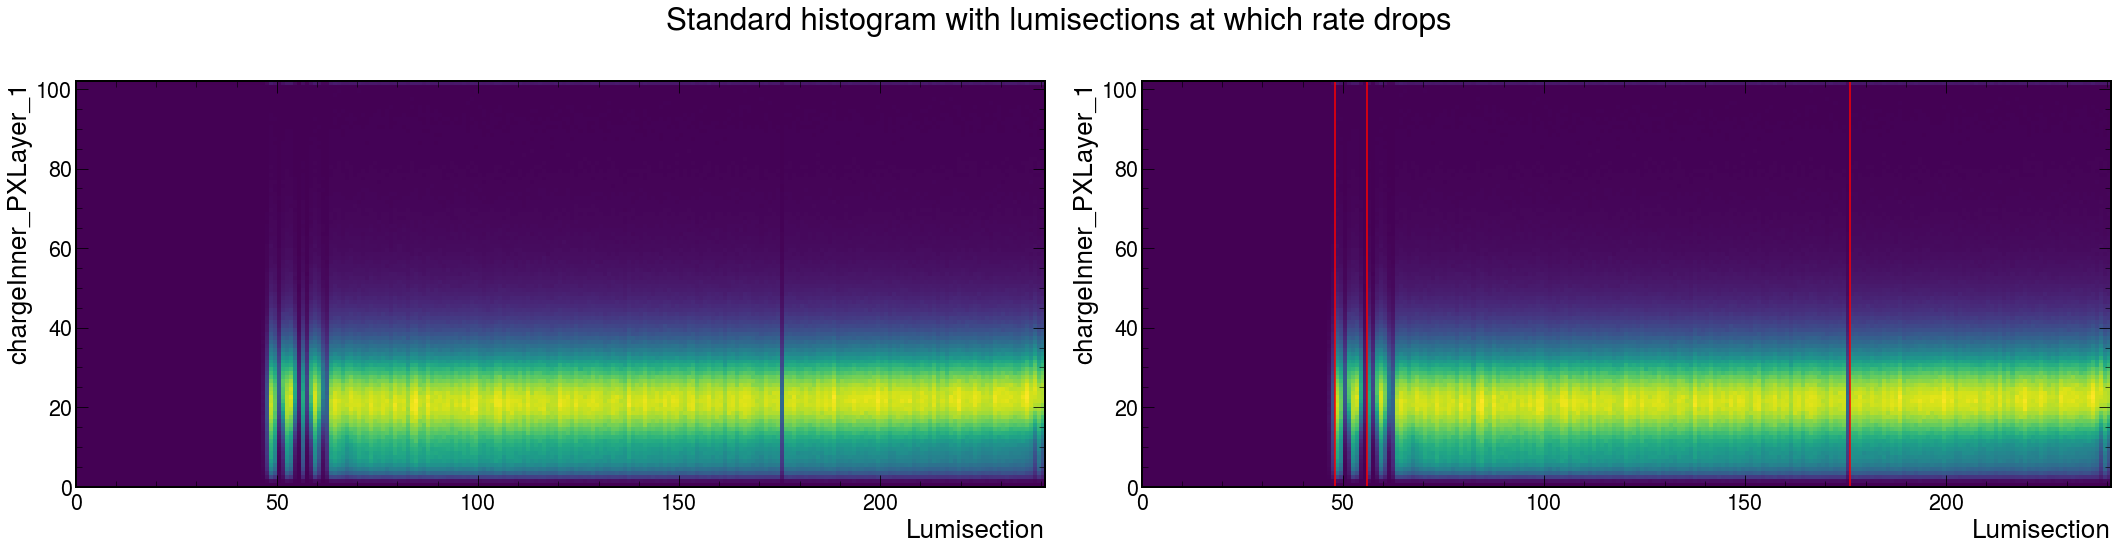

In [31]:
f,axs = plt.subplots(1,2,figsize=(30,8))
for peak in rate_peak_list : 
    plt.axvline(x = peak,color='r')
plt.subplot(121)
colorplot(df_test_run,'chargeInner_PXLayer_1',test_run,col_name='histo_list')
plt.subplot(122)
colorplot(df_test_run,'chargeInner_PXLayer_1',test_run,col_name='histo_list')
plt.suptitle("Standard histogram with lumisections at which rate drops")
plt.tight_layout()

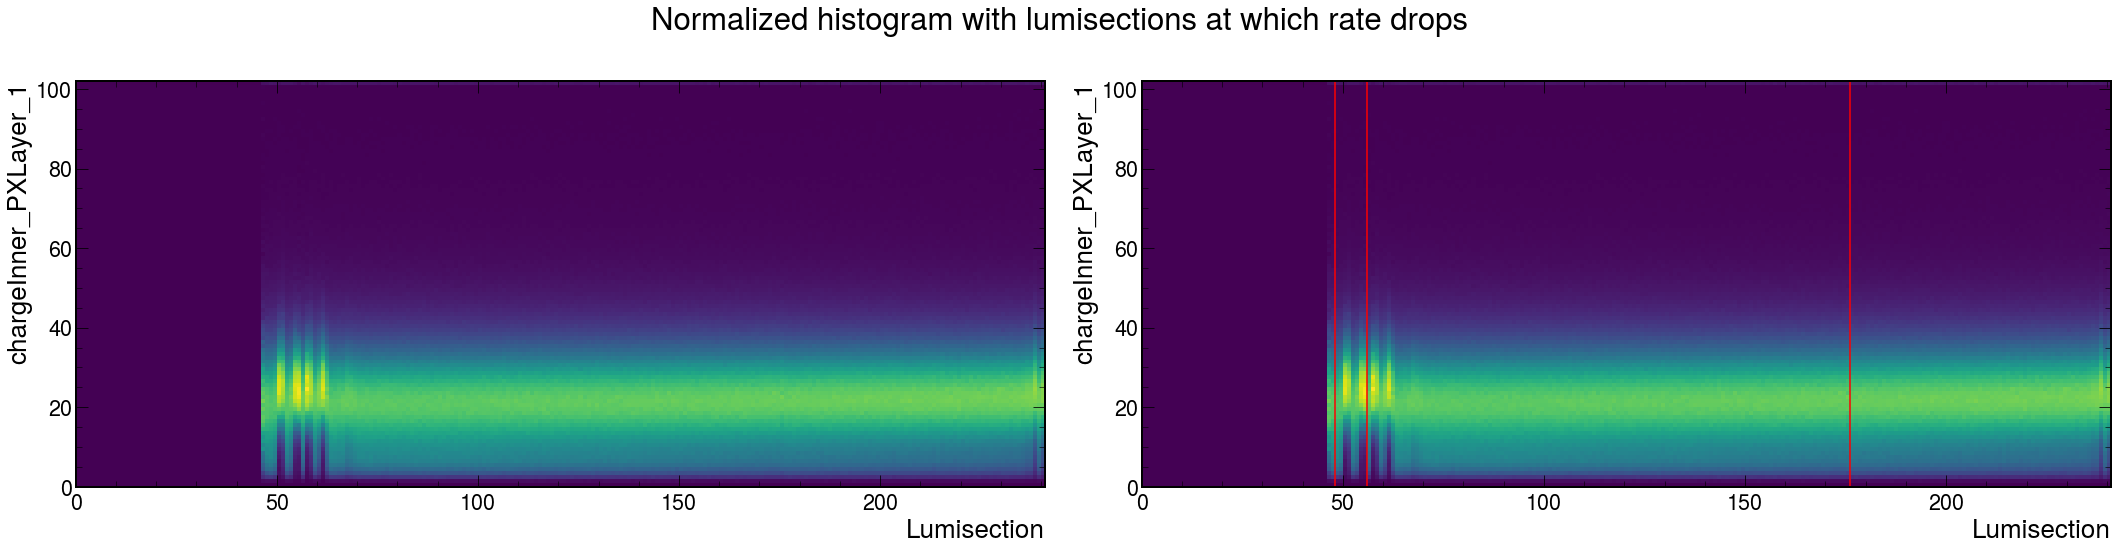

In [32]:
f,axs = plt.subplots(1,2,figsize=(30,8))
for peak in rate_peak_list : 
    plt.axvline(x = peak,color='r')
plt.subplot(121)
colorplot(df_test_run,'chargeInner_PXLayer_1',test_run,col_name='norm_histo_list')
plt.subplot(122)
colorplot(df_test_run,'chargeInner_PXLayer_1',test_run,col_name='norm_histo_list')
plt.suptitle("Normalized histogram with lumisections at which rate drops")
plt.tight_layout()


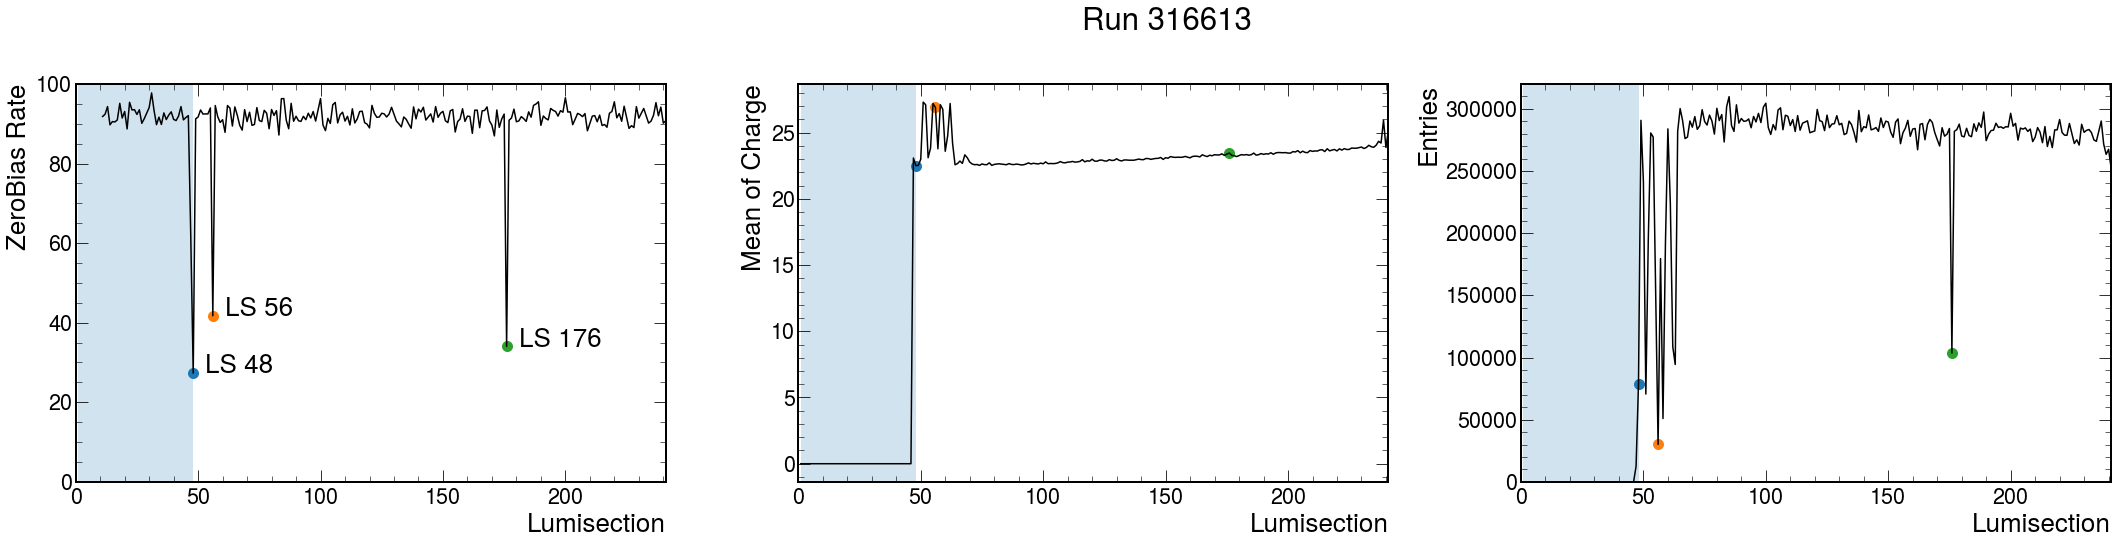

In [33]:
plt.subplots(figsize=(30,8))

#ZeroBias Rate Displaying
plt.subplot(131)
for peak in rate_peak_list :
    plt.plot(peak,df_zerobias['attributes.rate'][peak],"o",ms=10)
    plt.text(peak+5,df_zerobias['attributes.rate'][peak],"LS "+str(peak))
plt.plot(df_zerobias['attributes.rate'],label=(df_zerobias['attributes.dataset_name'][14]),color='k')
plt.xlim([0,max(df_zerobias.index)])
plt.ylim(0,100)
plt.xlabel('Lumisection')
plt.ylabel('ZeroBias Rate')
plt.axvspan(1,max(false_lumi_list),alpha=0.2)

#Histgram Mean Displaying
plt.subplot(132)
for peak in rate_peak_list :
    plt.plot(peak,mean_test_run['chargeInner_PXLayer_1'][peak],"o",ms=10)
for me in monitoring_elements[:1]:
    plt.plot(mean_test_run[me],label=me,color='k')
    plt.xlim([0,max(df_zerobias.index)])
    plt.ylabel('Mean of Charge')
    plt.xlabel('Lumisection')
plt.axvspan(1,max(false_lumi_list),alpha=0.2)

#Entries Displaying
plt.subplot(133)
for peak in rate_peak_list :
    plt.plot(peak,df_entries['entries'][peak],"o",ms=10)
for me in monitoring_elements[:1]:
    plt.plot(df_entries['entries'],label=me,color='k')
    plt.xlabel('Lumisection')
    plt.ylabel('Entries')
    plt.xlim([0,max(df_zerobias.index)])
    plt.ylim(0,320000)
    #plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.axvspan(1,max(false_lumi_list),alpha=0.2)

plt.suptitle('Run '+str(test_run),x=0.55,y=0.97)
plt.tight_layout()
#plt.savefig("picture3.png", bbox_inches='tight', dpi=50)


### *chargeInner_PXLayer_1* histogram at lumisection at which trigger rate drops

In [34]:
color = mcolors.TABLEAU_COLORS

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


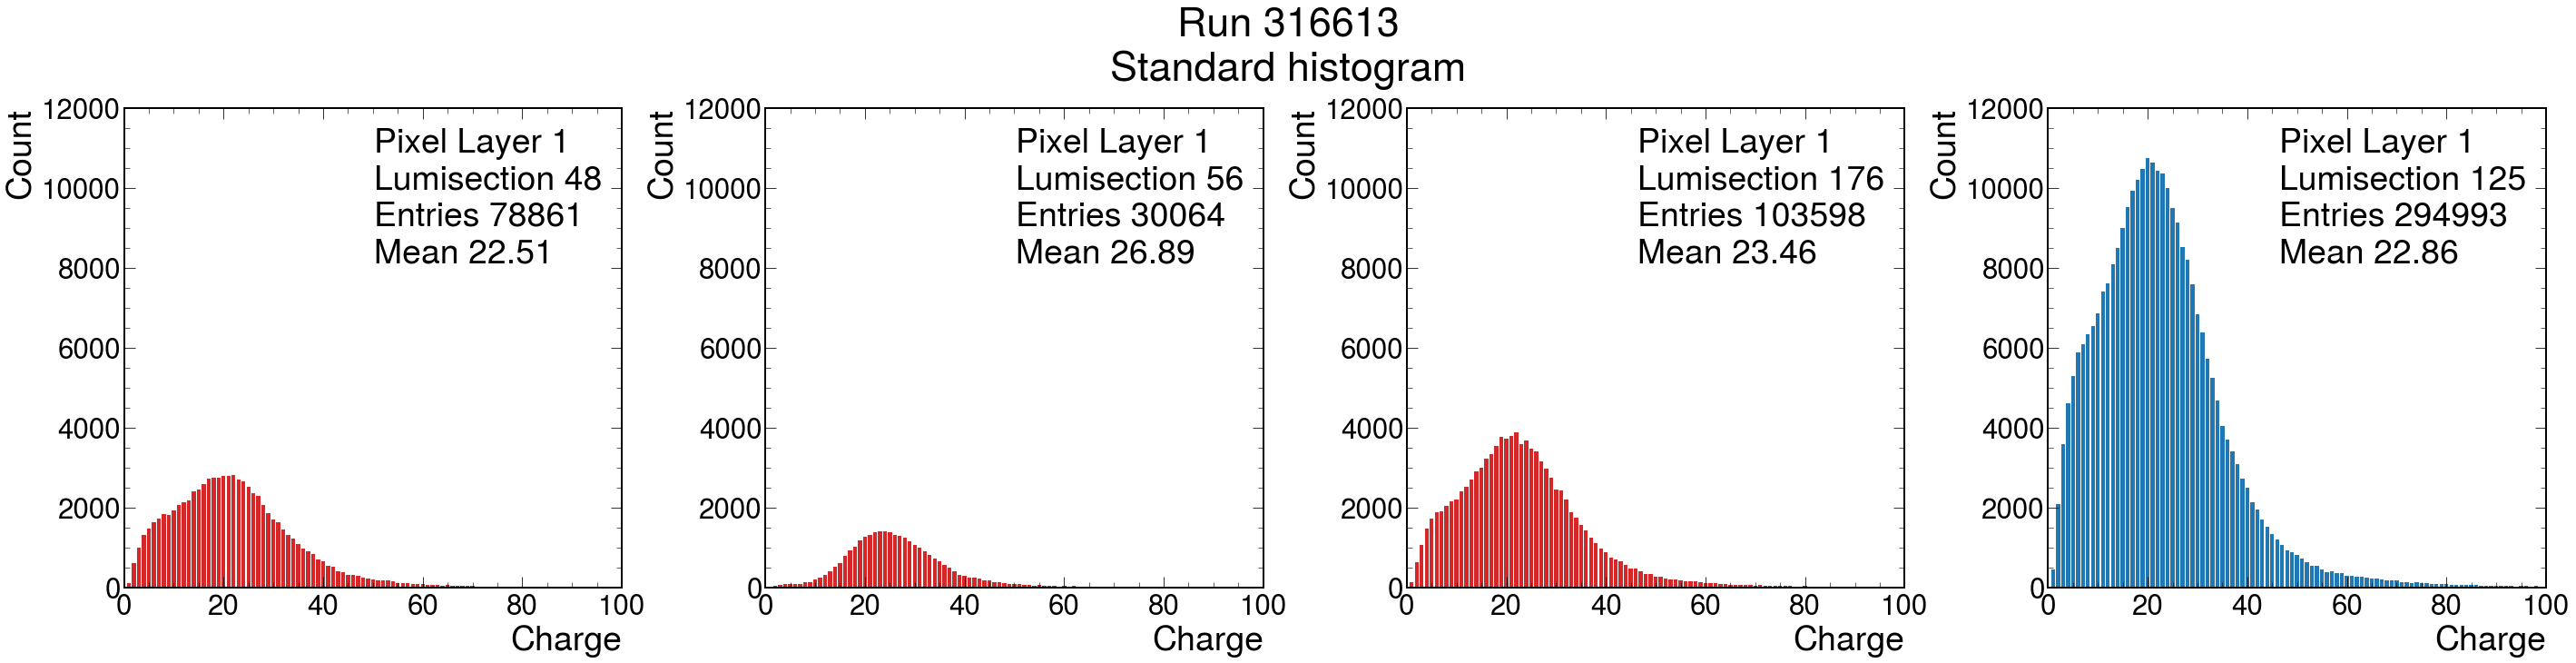

In [35]:
plt.subplots(1,4,figsize=(40,11))
i = 0
for peak in rate_peak_list :
    i +=1 
    plt.subplot(1,4,i)
    histogram_plot(run=test_run,lumisection = peak,histo='histo_list',color=color['tab:red'])
    plt.ylim([0,12000])
    plt.xlim(0,100)
plt.subplot(1,4,i+1)
histogram_plot(run=test_run,lumisection = 125,histo='histo_list',color=mcolors.TABLEAU_COLORS['tab:blue'])
plt.suptitle("Run "+str(test_run)+"\nStandard histogram",y=0.94,fontsize = 'xx-large')
plt.ylim([0,12000])
plt.xlim(0,100)
plt.tight_layout(w_pad=0.1)
plt.savefig("picture21.png", bbox_inches='tight', dpi=50)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


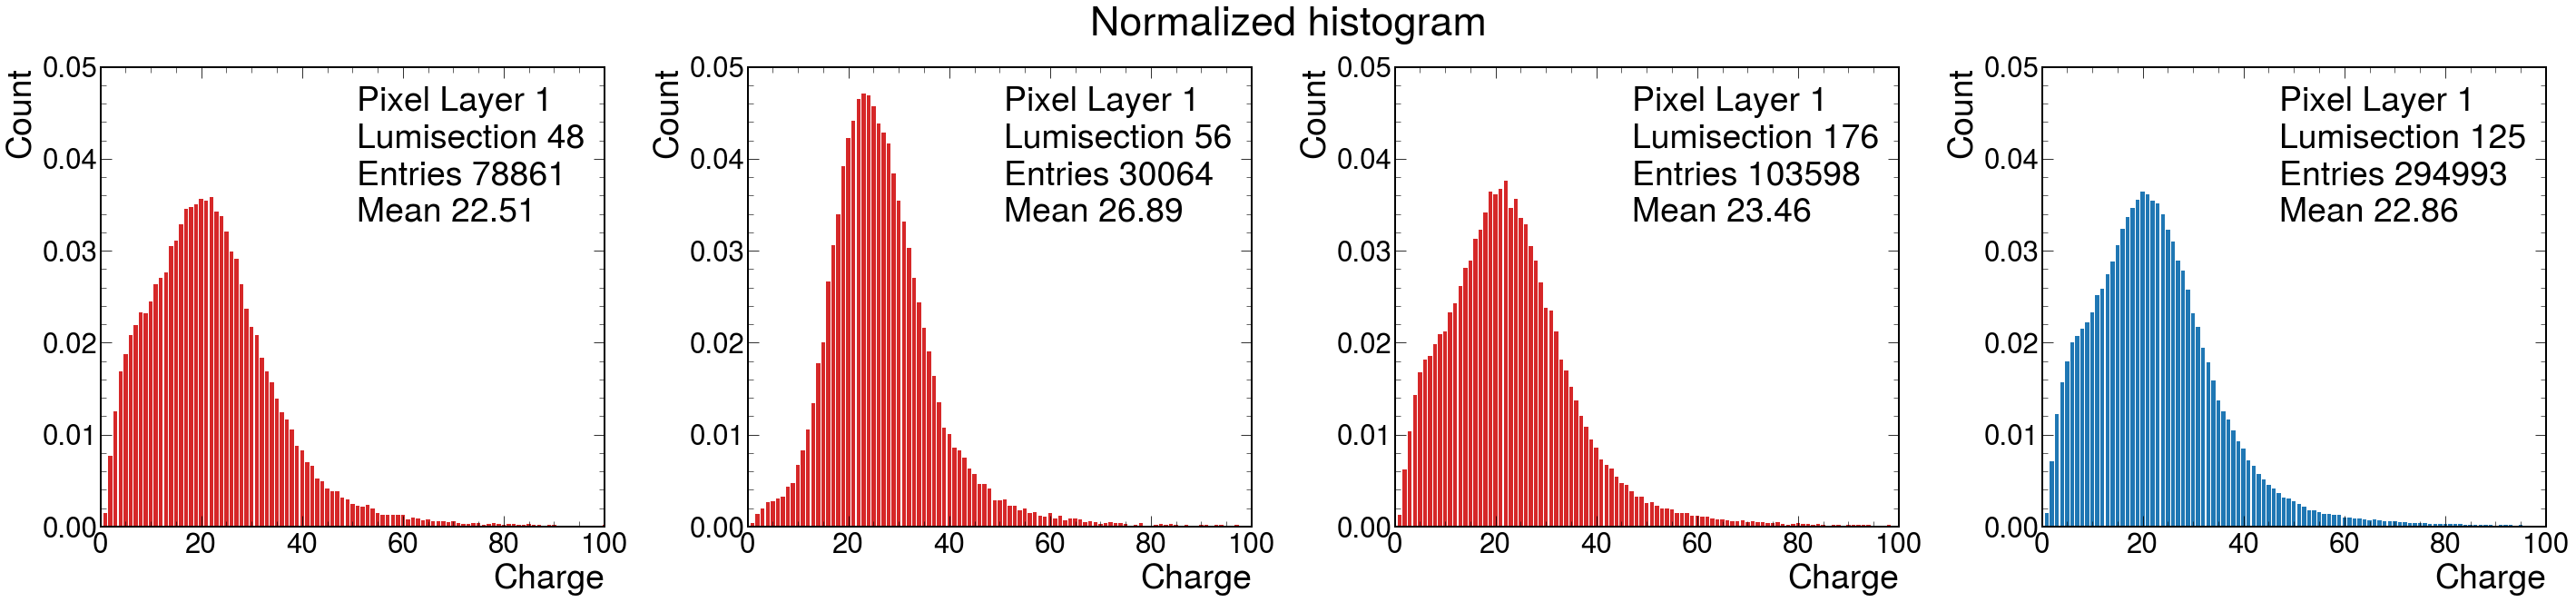

In [36]:
plt.subplots(figsize=(40,10))
i = 0
for peak in rate_peak_list :
    i +=1 
    plt.subplot(1,4,i)
    plt.ylim([0,0.05])
    plt.xlim(0,100)
    histogram_plot(run=test_run,lumisection = peak,histo='norm_histo_list',color=color['tab:red'])
plt.subplot(1,4,i+1)
histogram_plot(run=test_run,lumisection = 125,histo='norm_histo_list',color=color['tab:blue'])
plt.ylim([0,0.05])
plt.xlim(0,100)
plt.suptitle("Normalized histogram",y=0.94,fontsize = 'xx-large')
#plt.tight_layout(w_pad=0.8)
plt.tight_layout()
plt.savefig("picture22.png", bbox_inches='tight', dpi=200)



## Time Series Decomposition

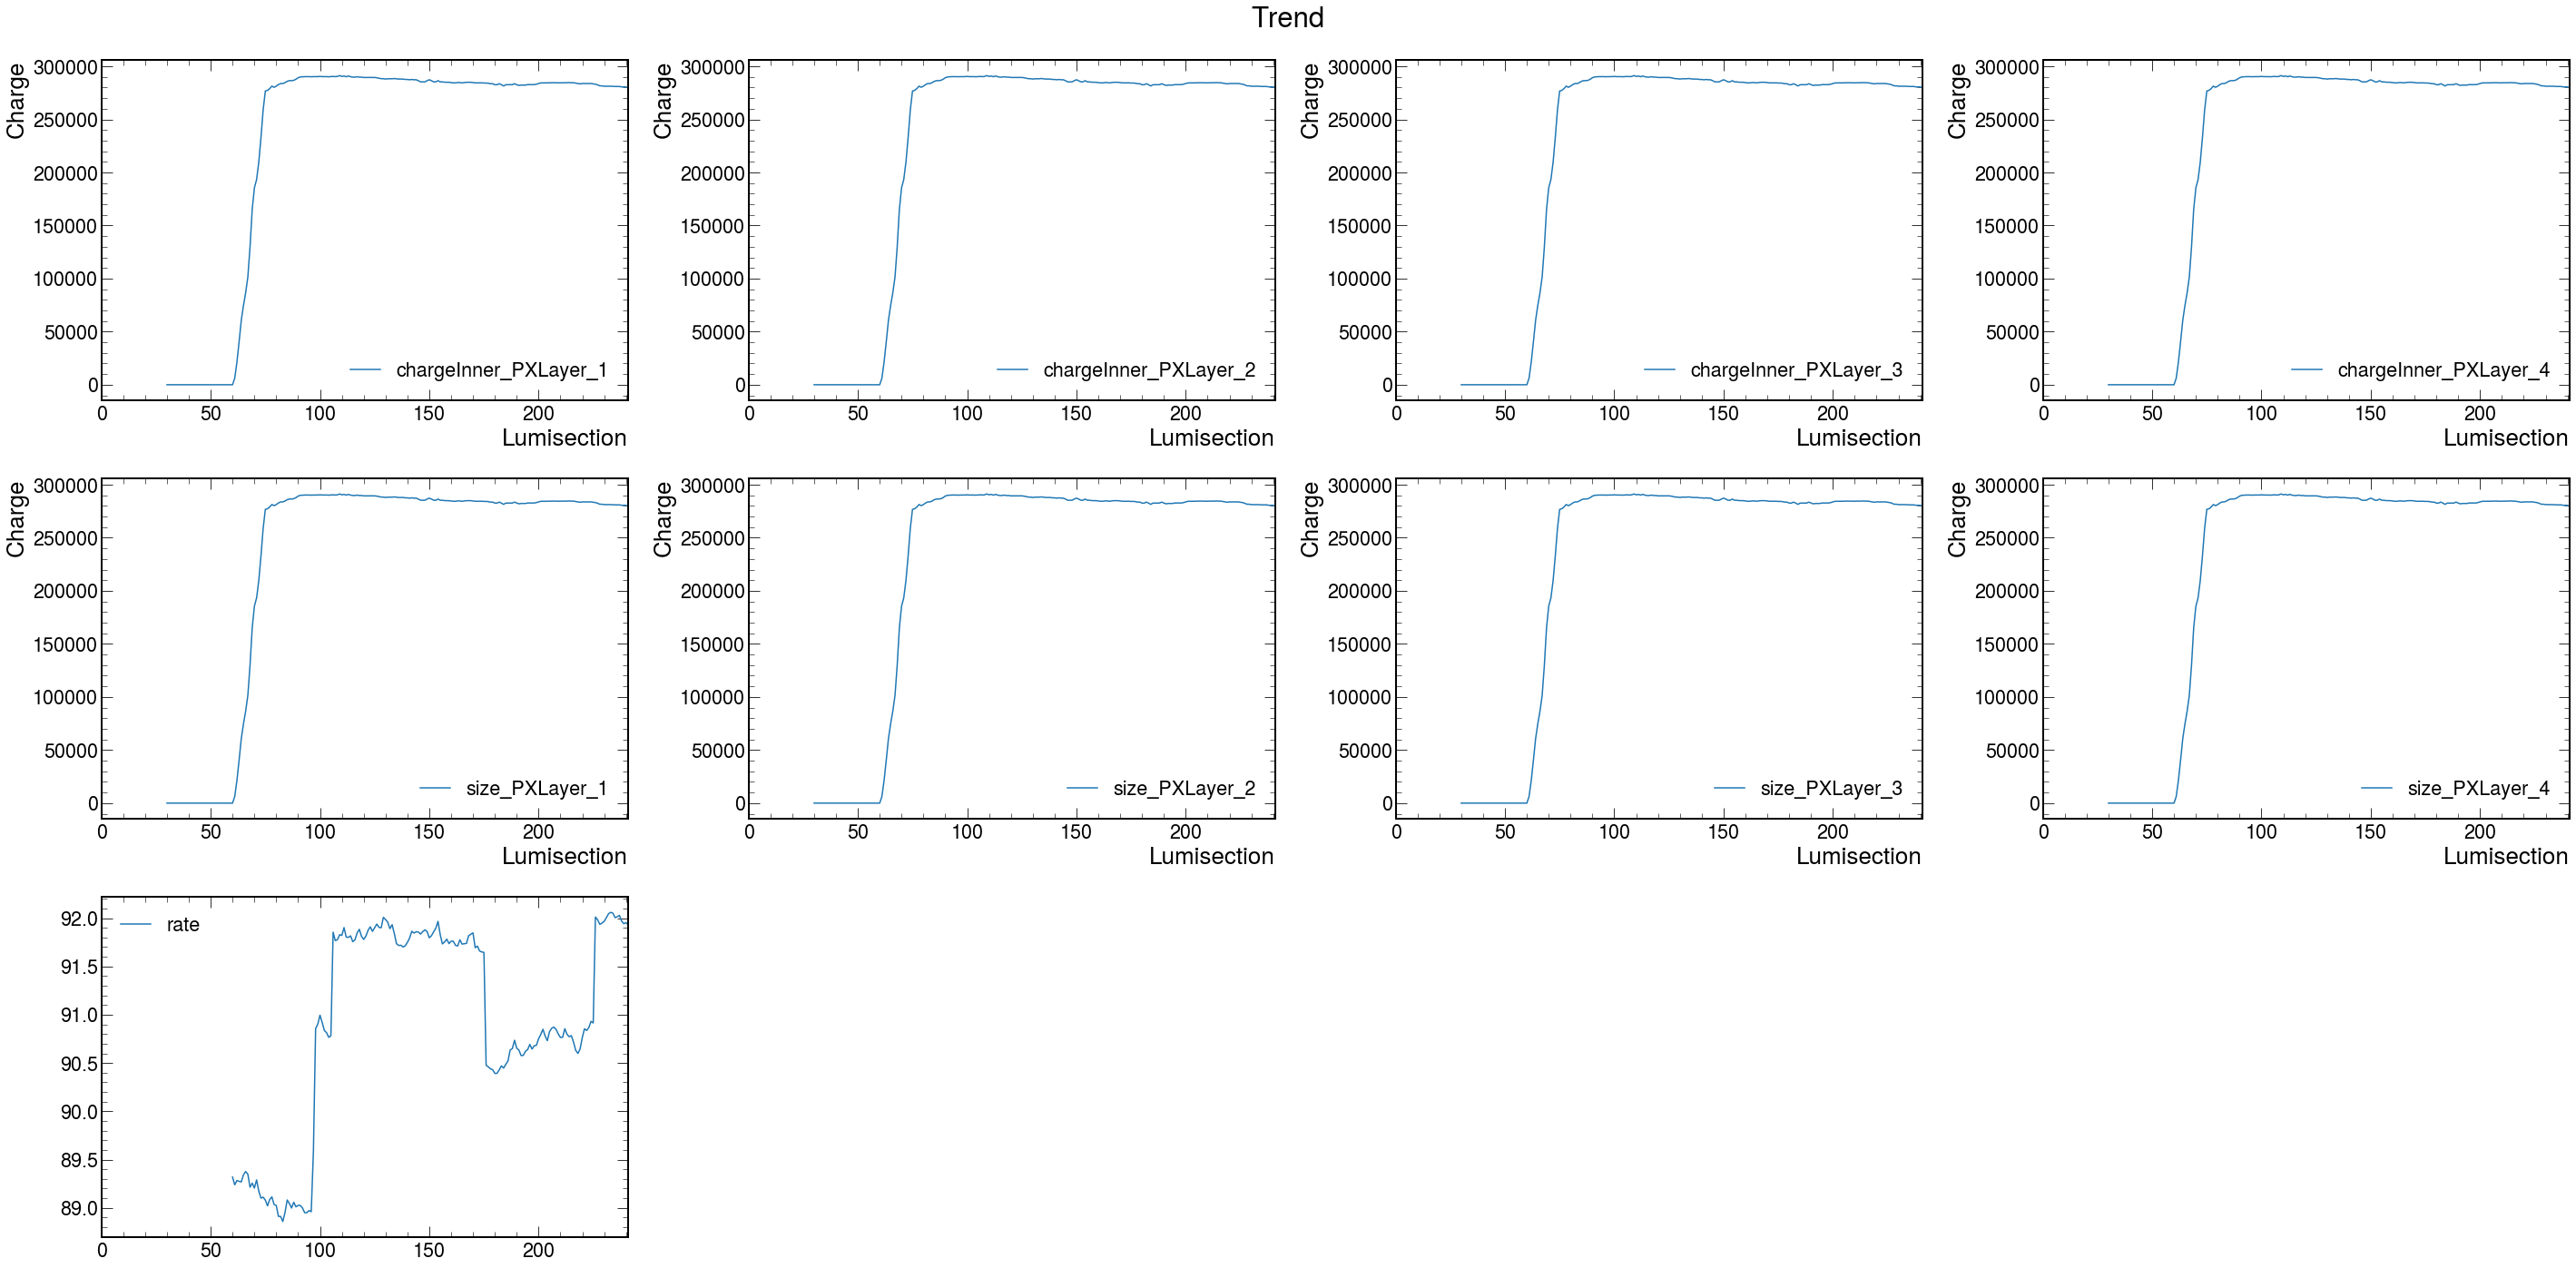

In [37]:
i=0
plt.subplots(figsize=(40,20))
for me in monitoring_elements :
    i+=1
    plt.subplot(3,4,i)
    plt.plot(df_entries['entries'].rolling(window=30).median(),label=me)
    plt.xlabel('Lumisection')
    plt.ylabel('Charge')
    plt.xlim(0,241)
    plt.legend()
plt.subplot(3,4,i+1)
plt.xlim(0,241)
plt.plot(df_zerobias['attributes.rate'].rolling(window=50).mean(),label='rate')
plt.ylim()
plt.legend()
plt.suptitle('Trend')
plt.tight_layout()

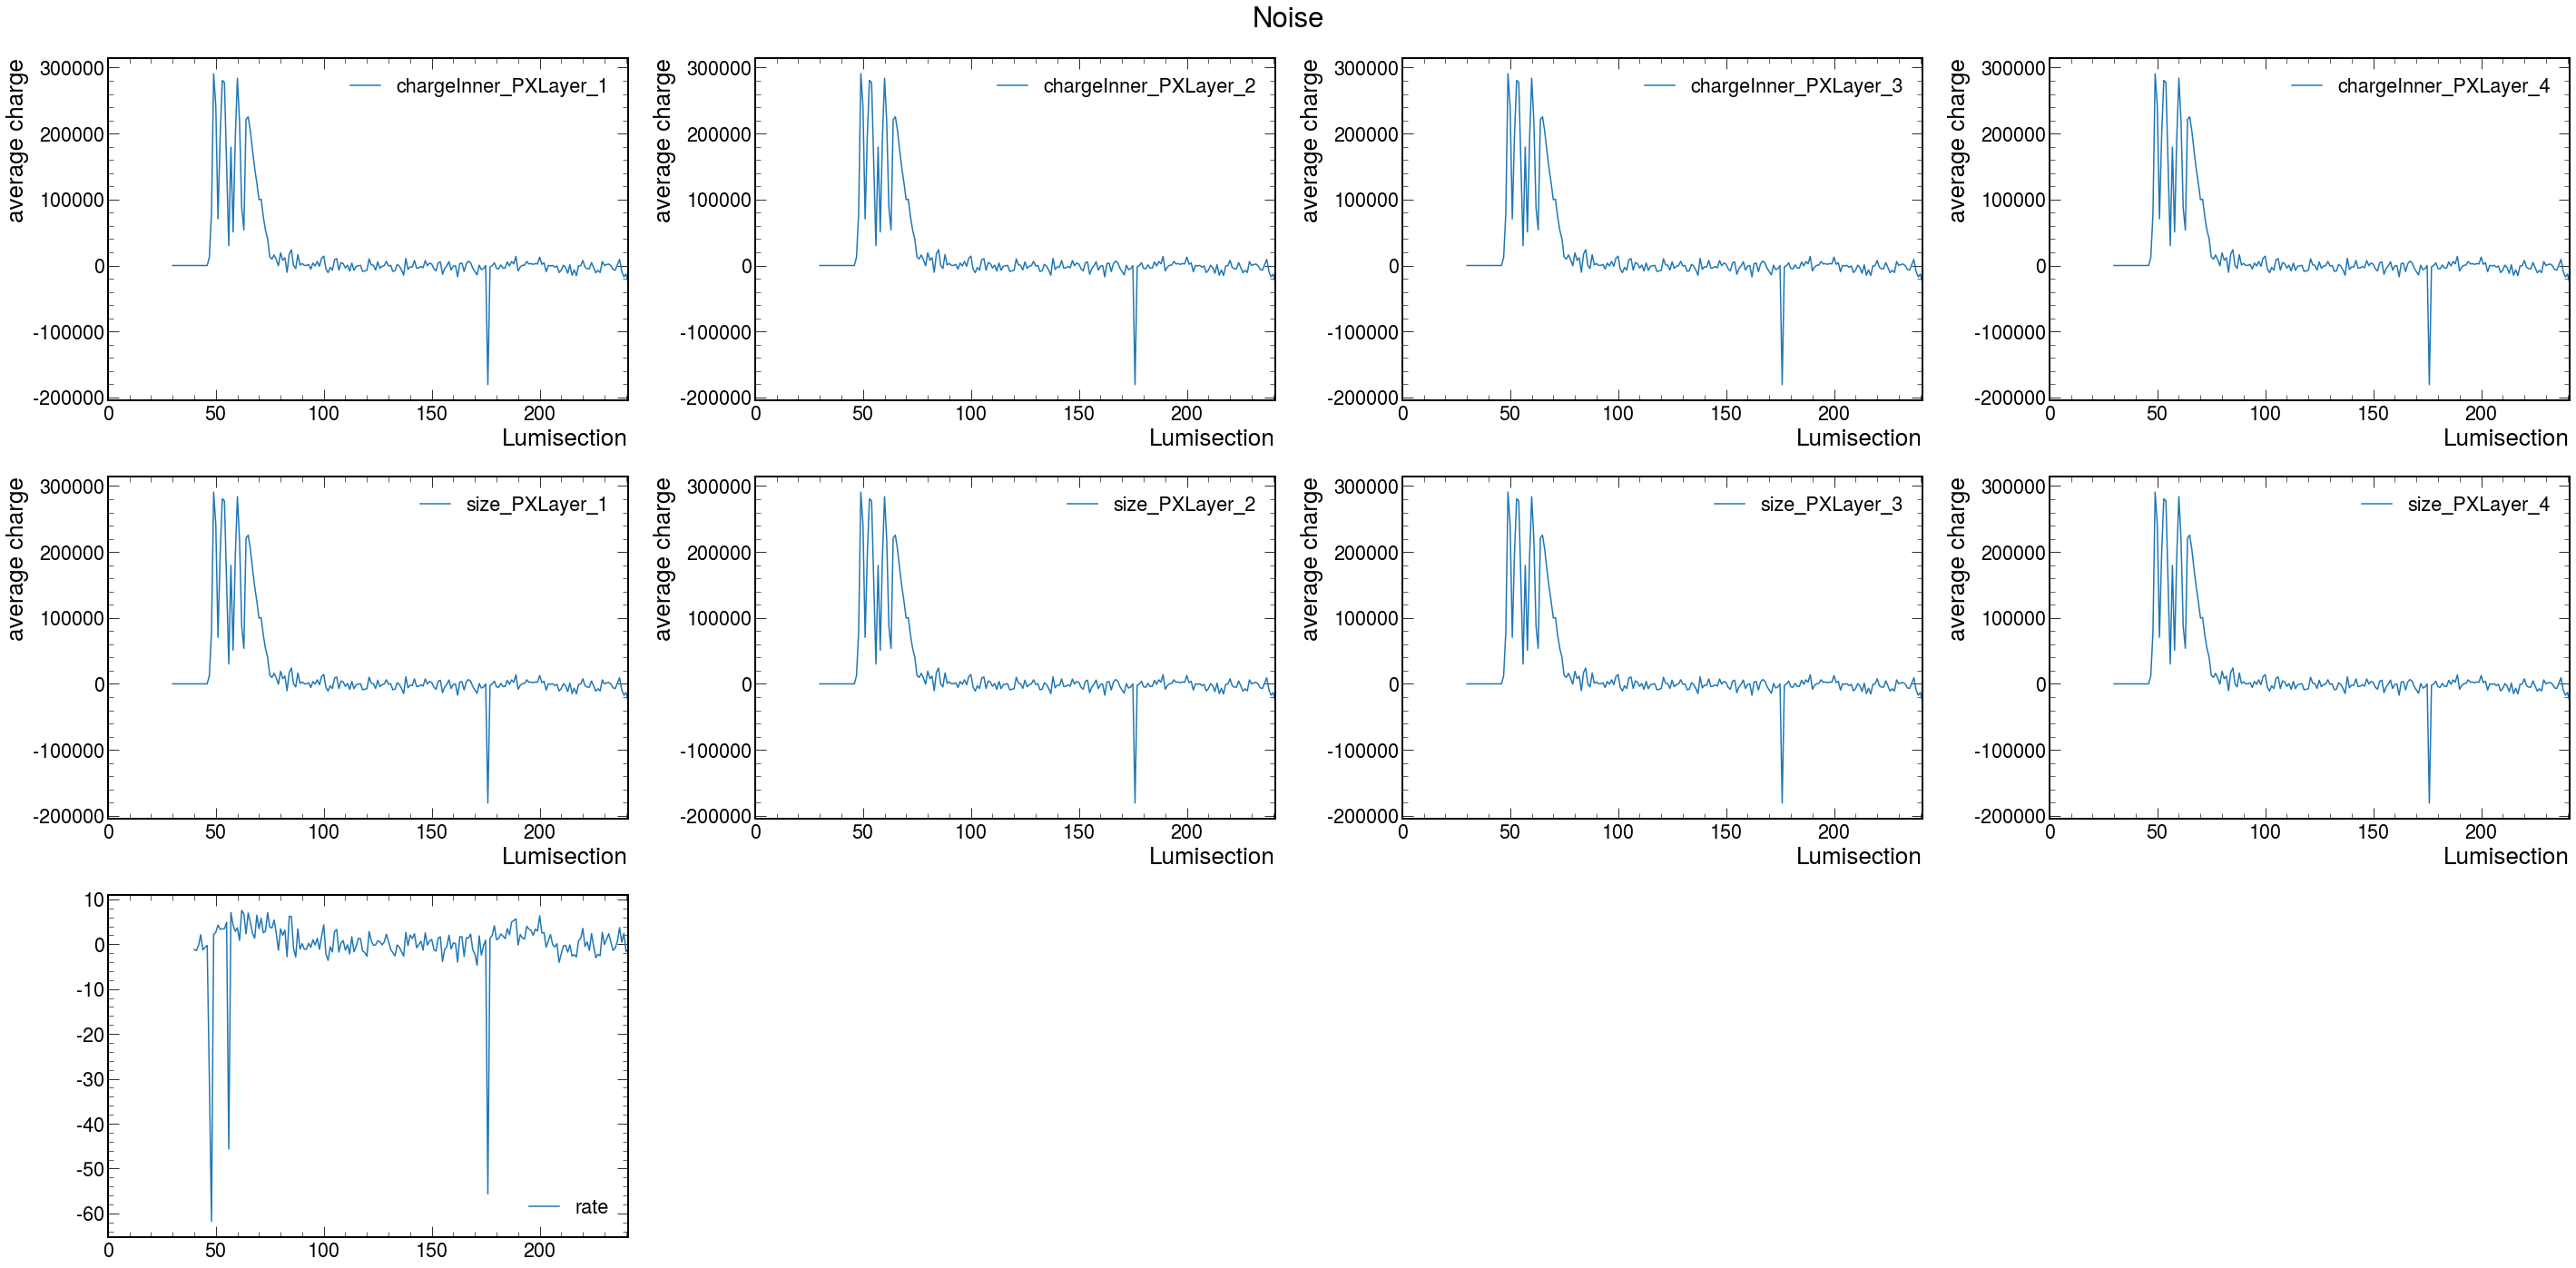

In [38]:
i=0
plt.subplots(figsize=(40,20))
for me in monitoring_elements :
    i+=1
    plt.subplot(3,4,i)
    plt.plot(df_entries['entries'] - df_entries['entries'].rolling(window=30).median(),label=me)
    plt.xlabel('Lumisection')
    plt.ylabel('average charge')
    plt.legend()
    plt.xlim(0,241)
    #plt.yscale('log')
plt.subplot(3,4,i+1)
plt.plot(df_zerobias['attributes.rate'] - df_zerobias['attributes.rate'].rolling(window=30).mean(),label='rate')
plt.xlim(0,241)
plt.legend()
plt.suptitle('Noise')
plt.tight_layout()    